In [1]:
import numpy as np
import cv2

import os
import random
import pickle

# Create dataset

In [21]:
categories = ['yes', 'no']
image_size = 150
images_per_category = 98
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join("dataset/brain_tumor_dataset", category)
        pictures = os.listdir(path)
        random.shuffle(pictures)
        class_idx = categories.index(category)
        selected_pictures = pictures[:images_per_category]
        #print(path)
        for img in selected_pictures:
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (image_size, image_size))
                training_data.append([new_array, class_idx])
            except Exception as e:
                print(e)

create_training_data()

In [25]:
X = []
y = []

for feature, label in training_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, image_size, image_size, 1)

In [29]:
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# Model training

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
pickle_X_in = open("X.pickle", "rb")
X = pickle.load(pickle_X_in)

pickle_y_in = open("y.pickle", "rb")
y = pickle.load(pickle_y_in)

X = X/255.0

X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=241)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [4]:
unique_val, counts_val = np.unique(y_val, return_counts=True)
print(np.asarray((unique_val, counts_val)).T)

[[ 0  8]
 [ 1 12]]


In [5]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(np.asarray((unique_train, counts_train)).T)  # classed are balanced

[[ 0 90]
 [ 1 86]]


In [6]:
X_train[0].shape

(150, 150, 1)

In [4]:
model = Sequential([
    Conv2D(128, (2, 2), activation="tanh", kernel_regularizer=regularizers.l2(0.01)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(128, (2, 2), activation="tanh", kernel_regularizer=regularizers.l2(0.01)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(128, (2, 2), activation="tanh", kernel_regularizer=regularizers.l2(0.01)),
    AveragePooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation="tanh"),
    Dense(1, activation="sigmoid")
])

learning_rate_schedule = ExponentialDecay( 0.0001, 1500, 0.8 )

opt = Adam(learning_rate=learning_rate_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics = ['accuracy']
)

history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    shuffle=True
)

Epoch 1/50
6/6 [==============================] - 23s 3s/step - loss: 3.2657 - accuracy: 0.5170 - val_loss: 3.3214 - val_accuracy: 0.4000
Epoch 2/50
6/6 [==============================] - 16s 2s/step - loss: 3.1851 - accuracy: 0.6250 - val_loss: 3.0693 - val_accuracy: 0.7500
Epoch 3/50
6/6 [==============================] - 22s 4s/step - loss: 3.0672 - accuracy: 0.7500 - val_loss: 3.0446 - val_accuracy: 0.6500
Epoch 4/50
6/6 [==============================] - 21s 4s/step - loss: 3.0090 - accuracy: 0.7386 - val_loss: 2.9722 - val_accuracy: 0.7500
Epoch 5/50
6/6 [==============================] - 20s 3s/step - loss: 2.9508 - accuracy: 0.7330 - val_loss: 2.9310 - val_accuracy: 0.7500
Epoch 6/50
6/6 [==============================] - 22s 4s/step - loss: 2.8993 - accuracy: 0.7443 - val_loss: 2.8862 - val_accuracy: 0.7500
Epoch 7/50
6/6 [==============================] - 19s 3s/step - loss: 2.8609 - accuracy: 0.7443 - val_loss: 2.8501 - val_accuracy: 0.7500
Epoch 8/50
6/6 [==================

In [7]:
model.save("model.keras")

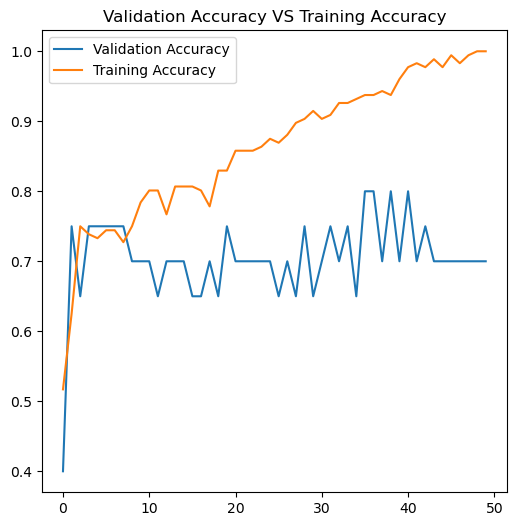

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(6, 6))
plt.plot(range(50), history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(range(50), history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title("Validation Accuracy VS Training Accuracy")
plt.show()

plt.savefig("Validation_Accuracy_VS_Training_Accuracy.jpeg")